## Paper baseline

#### 1) full string matching

In [1]:
import pandas as pd
import pickle
from typing import List, Any, Callable
from split_words import Splitter
import string
import seaborn as sns
from utils import select_candidates_from_taxonomy
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2


ESCO_DIR = "/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/esco/"
GENERATED_DIR = "/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/SkillThrills/protosp01/dataset_generation/generation/generated/"

def load_split(split):
    ESCO_DIR = "../../../esco/"
    with open(ESCO_DIR + split + ".json") as f:
        sp = eval(",".join(f.read().split("\n")))
    sp = pd.DataFrame(sp).drop("idx", axis=1)
    sp.columns = ["sentence", "skills"]
    sp = sp[["skills", "sentence"]]

    return sp

In [2]:
devsp = load_split("dev")
testsp = load_split("test")

In [3]:
def get_sp_emb_tax(split):
    if(split == "dev"):
        with open(ESCO_DIR + "dev_skillspan_emb.pkl", "rb") as emb:
            sp_emb_tax = pickle.load(emb)
    if(split == "test"):
        with open(ESCO_DIR + "test_skillspan_emb.pkl", "rb") as emb:
            sp_emb_tax = pickle.load(emb)

    sp_emb_tax["Example"] = sp_emb_tax["altLabels"]
    taxonomy = sp_emb_tax.drop("embeddings", axis=1)
    return sp_emb_tax, taxonomy

_, taxonomy1 = get_sp_emb_tax("test")
_, taxonomy2 = get_sp_emb_tax("dev")
taxonomy = pd.concat([taxonomy1, taxonomy2]).drop_duplicates("name")

def compute_metrics(all_skills, all_pred_skills, verbose=False):
    TP, FP, FN = 0, 0, 0
    for skills, pred_skills in zip(all_skills, all_pred_skills):
        for skill in skills:
            if(skill in pred_skills):
                TP += 1 ## predicted as true and is indeed
            else :
                FN += 1 ## predicted as false, but it was true
        
        for pred_skill in pred_skills:
            if(pred_skill not in skills):
                FP += 1 ## predicted as true but is false

    P = TP / (TP + FP) if (TP + FP) != 0 else 0
    R = TP / (TP + FN) if (TP + FN) != 0 else 0
    print("TP : ", TP,
          "FP : ", FP,
          "FN : ", FN) if verbose else None
    return P, R, (2*P*R / (P + R) if (P + R) != 0 else 0)

def print_metrics(ds, label_key="skills", pred_key="pred_skills", verbose=False):
    P, R, F1 = compute_metrics(list(ds[label_key].values), list(ds[pred_key].values), verbose)
    print("Precision : ", P)
    print("Recall : ", R)
    print("F1 : ", F1)
    return P, R, F1

In [4]:
len(get_sp_emb_tax("dev")[1]) + 454

602

In [5]:
len(pd.concat([
    get_sp_emb_tax("test")[1],
    get_sp_emb_tax("dev")[1]
]).drop_duplicates("name").index)

514

In [6]:
def long_match(span: str, sentence: str) -> bool: 
    span_w = [
        word.strip(string.punctuation) for word in span.split()
    ]
    sentence_w = [
        word.strip(string.punctuation) for word in sentence.split()
    ]
    N = len(span_w)
    return any(sentence_w[i:i+N] == span_w for i in range(len(sentence_w))) 

def short_match(name: str, sentence: str):
    return name in sentence


def full_match_predict(sentence: str, match_func: Callable[[str, str], bool]) -> List[str]:
    return list(taxonomy[taxonomy["name"].apply(
        lambda skname : match_func(skname, sentence)
    )]["name"].values)

In [7]:
devsp["pred_skills"] = devsp["sentence"].apply(lambda st : full_match_predict(st, long_match))
testsp["pred_skills"] = testsp["sentence"].apply(lambda st : full_match_predict(st, long_match))

In [8]:
print("DEV : ")
print_metrics(devsp, "skills", "pred_skills")
print("*"*100)
print("TEST : ")
print_metrics(testsp, "skills", "pred_skills")

DEV : 
Precision :  0.7692307692307693
Recall :  0.08498583569405099
F1 :  0.15306122448979592
****************************************************************************************************
TEST : 
Precision :  0.776595744680851
Recall :  0.05080027835768963
F1 :  0.0953625081645983


(0.776595744680851, 0.05080027835768963, 0.0953625081645983)

In [9]:
devsp["pred_skills"] = devsp["sentence"].apply(lambda st : full_match_predict(st, short_match))
testsp["pred_skills"] = testsp["sentence"].apply(lambda st : full_match_predict(st, short_match))
print("DEV : ")
print_metrics(devsp, "skills", "pred_skills")
print("*"*100)
print("TEST : ")
print_metrics(testsp, "skills", "pred_skills")

DEV : 
Precision :  0.49206349206349204
Recall :  0.08781869688385269
F1 :  0.14903846153846154
****************************************************************************************************
TEST : 
Precision :  0.41304347826086957
Recall :  0.05288796102992345
F1 :  0.09376927822331894


(0.41304347826086957, 0.05288796102992345, 0.09376927822331894)

In [10]:
devsp[["skills", "pred_skills"]].explode("skills")[["skills", "pred_skills"]].apply(
    lambda x : x["skills"] in x["pred_skills"], axis=1
).mean()

0.08781869688385269

#### 1) Rule based matching

In [11]:
from sys import path as syspath
syspath.append("../dataset_generation/")
from dataset_evaluation import Predictor, ESCO_DIR, get_sp_emb_tax

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
## IF WE WANT TO GET THE REAL PIPELINE EXTRACTION
# predr = Predictor(
#     test_domain="SkillSpan-dev+test",
#     train_domain="SkillSpan",
#     candidates_method="rules"
# )

In [14]:
with open("../dataset_generation/predictions/preds_support_type_None.pkl", 'rb') as f:
    devpreds = pickle.load(f)

In [15]:
devextr = [[x[0]["sentence"], x[0]["extracted_skills"]] for x in devpreds]
devextr = pd.DataFrame(devextr)
devextr.columns = ["sentence", "spans"]

In [16]:
assert(len(devsp) == len(devextr.merge(devsp, on="sentence")))
devsp = devextr.merge(devsp, on="sentence")
devsp.sample(5)

,sentence,spans,skills,pred_skills
19,Your main responsibilities will be to: Plan an...,[plan and ensure development of global constru...,[UNK],[]
45,The tasks can be feeding moving castration ins...,"[feeding, moving, castration, insemination, mo...","[feed livestock, UNK, insert semen, monitor th...",[]
140,python,[],[Python (computer programming)],[]
30,As a person you are outgoing of nature and you...,"[outgoing, natural project management skills]","[UNK, project management]",[project management]
67,Drive the annual salary review across HQ inclu...,"[drive the annual salary review, benchmarking ...",[determine salaries],[R]


In [17]:
_, taxonomy1 = get_sp_emb_tax("test")
_, taxonomy2 = get_sp_emb_tax("dev")
taxonomy = pd.concat([taxonomy1, taxonomy2]).drop_duplicates("name")

def get_skills_for_span(spans: List[str], nb_cand: int) -> List[str]:
    splitter = Splitter()
    candidates = select_candidates_from_taxonomy( ## BOTTLENECK 2
        {
            "extracted_skills":spans,
            "sentence": ...,
        }, 
            taxonomy,
            splitter=splitter,
            tokenizer=None,
            model=None,
            max_candidates=nb_cand,
            method="rules", ### COMPARE WITH MIXED AND CANDIDATEDS WILL THEN BE 20 AS FOR THE RUN 
            emb_tax = None
    )
    return list(set(
        sum([
        [
            x["name+definition"].split(" : ")[0]
            for x in candidates["skill_candidates"][sk]
        ]
        for sk in spans
    ], [])
    ))

In [18]:
for i in range(1, 11):
    print(f"{i} candidates : {len(get_skills_for_span(['Java', 'geography'], i))} retrieved")

1 candidates : 1 retrieved
2 candidates : 2 retrieved
3 candidates : 6 retrieved
4 candidates : 7 retrieved
5 candidates : 8 retrieved
6 candidates : 9 retrieved
7 candidates : 10 retrieved
8 candidates : 11 retrieved
9 candidates : 12 retrieved
10 candidates : 13 retrieved


In [19]:
baseline_metrics = []
for i in range(1, 11):
    devsp["pred_skills"] = devsp.spans.apply(
        lambda x : get_skills_for_span(x, i))
    baseline_metrics.append(
        print_metrics(devsp, "skills", "pred_skills")
    )

Precision :  0.24193548387096775
Recall :  0.16997167138810199
F1 :  0.19966722129783696
Precision :  0.1711340206185567
Recall :  0.23512747875354106
F1 :  0.19809069212410502
Precision :  0.12867132867132866
Recall :  0.26062322946175637
F1 :  0.17228464419475656
Precision :  0.10178384050367262
Recall :  0.2747875354107649
F1 :  0.14854517611026036
Precision :  0.08431703204047218
Recall :  0.28328611898017
F1 :  0.1299545159194282
Precision :  0.07294617563739376
Recall :  0.29178470254957506
F1 :  0.11671388101983003
Precision :  0.06593406593406594
Recall :  0.3059490084985836
F1 :  0.10848819688598696
Precision :  0.05964535196131112
Recall :  0.31444759206798867
F1 :  0.1002710027100271
Precision :  0.05571565802113353
Recall :  0.3286118980169972
F1 :  0.09527720739219712
Precision :  0.053315994798439535
Recall :  0.34844192634560905
F1 :  0.0924812030075188


In [20]:
baseline_metrics

[(0.24193548387096775, 0.16997167138810199, 0.19966722129783696),
 (0.1711340206185567, 0.23512747875354106, 0.19809069212410502),
 (0.12867132867132866, 0.26062322946175637, 0.17228464419475656),
 (0.10178384050367262, 0.2747875354107649, 0.14854517611026036),
 (0.08431703204047218, 0.28328611898017, 0.1299545159194282),
 (0.07294617563739376, 0.29178470254957506, 0.11671388101983003),
 (0.06593406593406594, 0.3059490084985836, 0.10848819688598696),
 (0.05964535196131112, 0.31444759206798867, 0.1002710027100271),
 (0.05571565802113353, 0.3286118980169972, 0.09527720739219712),
 (0.053315994798439535, 0.34844192634560905, 0.0924812030075188)]

In [21]:
baseline_metrics = pd.DataFrame(baseline_metrics)
baseline_metrics.columns = ["Precision", "Recall", "$F_1$"]
baseline_metrics["candidates"] = list(range(1, 11))

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/

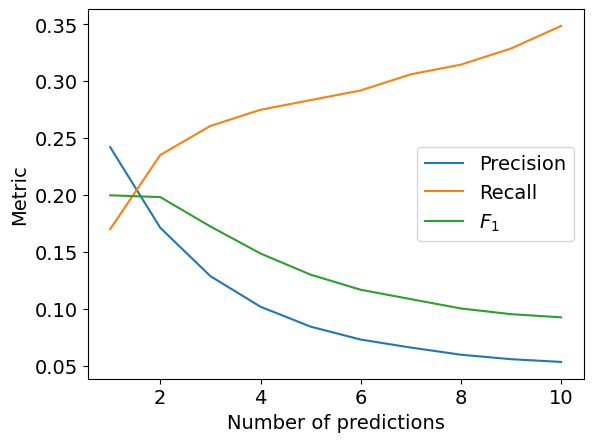

In [24]:
plt.rcParams.update({'font.size': 14})

sns.lineplot(data=baseline_metrics, x="candidates", y="Precision", label="Precision")
sns.lineplot(data=baseline_metrics, x="candidates", y="Recall", label="Recall")
g = sns.lineplot(data=baseline_metrics, x="candidates", y="$F_1$", label="$F_1$")
g.set_xlabel("Number of predictions")
g.set_ylabel("Metric")
plt.legend()

plt.savefig("ablation_matching.pdf", dpi=1000)

In [ ]:
nb_candidates = 2
testsp["pred_skills"] = testsp.spans.apply(
        lambda x : get_skills_for_span(x, nb_candidates)
)

AttributeError: 'DataFrame' object has no attribute 'spans'